# DATA 612 Project 2 - Joke Recommender System Part II

By Mike Silva

## Introduction

This is the continuation of the creation of a recommender system that provides users with jokes that they will find funny.  By providing this content we will keep users engaged longer on the website.

### About the Jester Dataset

For this project I will be using the [Jester dataset](http://eigentaste.berkeley.edu/dataset/).  It was created by Ken Goldberg at UC Berkley (Eigentaste: A Constant Time Collaborative Filtering Algorithm. Ken Goldberg, Theresa Roeder, Dhruv Gupta, and Chris Perkins. Information Retrieval, 4(2), 133-151. July 2001).

Data files are in .zip format, when unzipped, they are in Excel (.xls) format.  The ratings are real values ranging from -10.00 to +10.00 (the value "99" corresponds to "null" meaning "not rated").  Each row is a user.  The first column gives the number of jokes rated by the user. The next 100 give the ratings for jokes 1 to 100.  I will only be the first data set that has data for users that have rated 36 or more jokes.  

In addition to the ratings, we will be using the actual joke content.  It is also available through the website in a .zip file.  Each joke is in an HTML file.  There are comments in the HTML that indicate where the joke begins and where it ends.  I will note that some of the text in the HTML files is poorly done.  There are cases where there aren't spaces after punctuation marks and they didn't follow HTML standards.  There will be some cleanup of the text of the jokes.

### data612

This notebook relies on the module I created for this class.  You can see the [data612 module here](https://github.com/mikeasilva/CUNY-SPS/blob/master/DATA612/data612.py).

## Data Aquisition

We will begin by loading the libraries we need and aquiring the data.  As I previously noted, the ratings were previously downloaded in Part I; but I include the code in case someone starts from this juncture.  Let's download the joke text and the ratings.

In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import requests
import scipy.cluster.hierarchy as hclust
import seaborn as sb
from shutil import rmtree
from sklearn.preprocessing import normalize
import zipfile
# Import my custom module for this class
import data612

%matplotlib inline

# STEP 1 - DOWNLOAD THE DATA SET
if not os.path.exists("jester_dataset_1_joke_texts.zip"):
    # We need to download it
    response = requests.get("http://eigentaste.berkeley.edu/dataset/jester_dataset_1_joke_texts.zip")
    if response.status_code == 200:
        with open("jester_dataset_1_joke_texts.zip", "wb") as f:
            f.write(response.content)
## This was done in Part I but we will include this just in case
if not os.path.exists("jester_dataset_1_1.zip"):
    # We need to download it
    response = requests.get("http://eigentaste.berkeley.edu/dataset/jester_dataset_1_1.zip")
    if response.status_code == 200:
        with open("jester_dataset_1_1.zip", "wb") as f:
            f.write(response.content)
# STEP 2 - EXTRACT ALL FILES
if not os.path.exists("jokes"):
    with zipfile.ZipFile("jester_dataset_1_joke_texts.zip","r") as z:
        z.extractall()
    # CLEANUP
    rmtree("__MACOSX")
## Again this was done in Part I but we are including this just in case
if not os.path.exists("jester-data-1.xls"):
    with zipfile.ZipFile("jester_dataset_1_1.zip","r") as z:
        z.extract("jester-data-1.xls")

We will also use the training and test set generated in Part I for modeling and evaluation in Part II.

In [2]:
if not os.path.exists("project_1_train_df.csv") or not os.path.exists("project_1_test_df.csv"):
    df = pd.read_excel("jester-data-1.xls",  header=None, na_values = 99)
    df = df.drop([0], axis=1)
    train_df, test_df = data612.train_test_split(df)
    train_df.to_csv("project_1_train_df.csv", index = False)
    test_df.to_csv("project_1_test_df.csv", index = False)
else:
    train_df = pd.read_csv("project_1_train_df.csv")
    test_df = pd.read_csv("project_1_test_df.csv")


## Content-Based Filtering

In this section I will develop a content-based filtering.  The recommender system will recommend jokes based on similar content.  Now that the jokes have been downloaded we need to read in the joke text into a list for processing:

In [3]:
jokes = list()

for n in range(1, 101):
    joke_text = data612.read_joke(n)
    jokes.append(joke_text)

### TF-IDF

Now that I have the content of the jokes I will preprocess the text.  I will remove the numbers and expand all contractions.  Then compute the TF-IDF.  We will use the cosine similarity of the TF-IDF to find similar jokes on the basis of the joke's text.

In [4]:
preprocessed_jokes = data612.preprocess_jokes(jokes, remove_numbers=True, remove_contractions=True)
tfidf_df = data612.tf_idf(preprocessed_jokes)
cosine_similarity_df = data612.cosine_similarity(tfidf_df)

Now that we have that let's visualize the results:

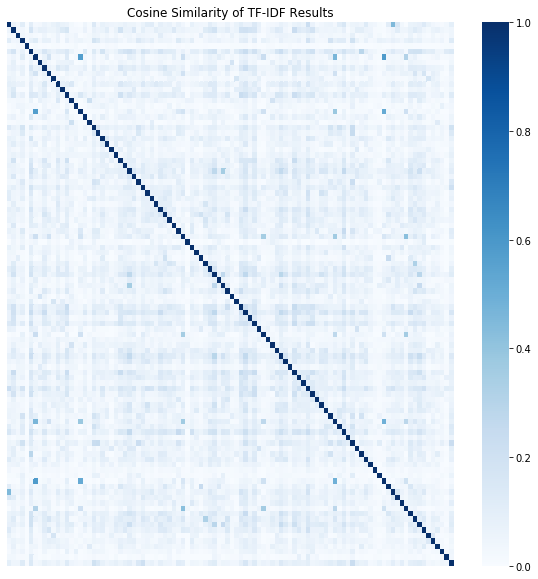

In [5]:
plt.figure(figsize=(10, 10))
plt.title("Cosine Similarity of TF-IDF Results") 
sb.heatmap(cosine_similarity_df, cmap="Blues", xticklabels=False, yticklabels=False)
plt.ylabel('')
plt.xlabel('')
plt.show()

This visualization suggests that TF-IDF is not very effective on the conent of the jokes. Let's see how well this preforms.  Based on the preceeding visualization I'm not expecting very good recommendations. Let's try it out on the first joke:

In [6]:
print(data612.read_joke(1))

A man visits the doctor. The doctor says "I have bad news for you.You have cancer and Alzheimer's disease". The man replies "Well,thank God I don't have cancer!"


Let's generate some recommendations and see how this approach preforms.  We will pick the 5 closest matches based on their cosine similarity to joke number 1.  They will be ordered in the closest match (or best recommendation) to the farthest match (worst recommendation).

In [7]:
content_recommendations = data612.get_cosine_based_joke_recommendations(cosine_similarity_df, joke_id = 1, n_recommendations = 5)
content_recommendations

[87, 68, 88, 76, 20]

In [8]:
print(data612.read_joke(content_recommendations[0]))

A man, recently completing a routine physical examination receives a phone call from his doctor. The doctor says, "I have some good news and some bad news." The man says, "OK, give me the good news first." The doctor says, "The good news is, you have 24 hours to live." The man replies, "Shit! That's the good news? Then what's the bad news?" The doctor says, "The bad news is, I forgot to call you yesterday."


That one was suprisingly similar.  They both were doctor patient jokes.  If you found joke number to be funny, this isn't a bad content based recommendation.  Perhaps I was too hard on the model.  Let's see the next recommendation.

In [9]:
print(data612.read_joke(content_recommendations[1]))

A man piloting a hot air balloon discovers he has wandered off course and is hopelessly lost. He descends to a lower altitude and locates a man down on the ground. He lowers the balloon further and shouts "Excuse me, can you tell me where I am?" The man below says: "Yes, you're in a hot air balloon, about 30 feet above this field." "You must work in Information Technology," says the balloonist. "Yes I do," replies the man. "And how did you know that?" "Well," says the balloonist, "what you told me is technically correct, but of no use to anyone." The man below says, "You must work in management." "I do," replies the balloonist, "how did you know?" "Well," says the man, "you don't know where you are, or where you're going, but you expect my immediate help. You're in the same position you were before we met, but now it's my fault!"


That one had nothing to do with the first one.  I guess my first sentiment was right on.

In [10]:
print(data612.read_joke(content_recommendations[2]))

A Czechoslovakian man felt his eyesight was growing steadily worse, and felt it was time to go see an optometrist. The doctor started with some simple testing, and showed him a standard eye chart with letters of diminishing size: CRKBNWXSKZY. . . "Can you read this?" the doctor asked. "Read it?" the Czech answered. "Doc, I know him!"


It is another doctor patient joke, but the fact that it is in this order indicates the is more work to do to get this to work right.

In [11]:
print(data612.read_joke(content_recommendations[3]))

There once was a man and a woman that both got in a terrible car wreck. Both of their vehicles were completely destroyed, buy fortunately, no one was hurt. In thankfulness, the woman said to the man, 'We are both okay, so we should celebrate. I have a bottle of wine in my car, let's open it.' So the woman got the bottleout of the car, and handed it to the man. The man took a really big drink, and handed the woman the bottle. The woman closed the bottle and put it down. The man asked, 'Aren't you going to take a drink?' The woman cleverly replied, 'No, I think I'll just wait for the cops to get here.'


Ah!  It seems the second and this last joke were recommended because they were both about a "man."  If you find this joke about a man funny perhaps you will find this other joke about a man funny.  I guess there may be some people that could share that kind of thinking, but I personally find the recommendations to be poor.  Let's take a look at the last recommendation.

In [12]:
print(data612.read_joke(content_recommendations[4]))

What's the difference between a MacIntosh and an Etch-A-Sketch? You don't have to shake the Mac to clear the screen.


I am not sure why this joke was recommended based off of the first joke.  I don't see any strong similarity.  I would personally call this a poor recommendation.  But that is my opinion.  Let's test this against some data.

### Evaluation Technique

In evaluating these recommendations we will say a recommendation can either be a "good" recommendation or a "bad" recommendation.  The point of this recommendation system is to provided content to the user that they will like.  The joke ratings range from -10 to 10.  We will say that any joke with a 5 or higher is content that the user likes.  Everything else they dislike.

We will evaluate the content based recommendations by identifying those records where people "liked" joke number 1.  We will look at if they liked or disliked the recommended joke.  We will measure the percent of the time our prediction was accurate.  We will load in all the jokes, and see how the recommendation engine preformed.

In [13]:
df = pd.read_excel("jester-data-1.xls",  header=None, na_values = 99)
df = df.drop([0], axis=1)

In [71]:
like_threshold = 5
likes_joke_one = df[df[1] >= like_threshold]
likes_joke_one

def evaluate_joke_recommendations(df, recommendations, like_threshold): 
    # Subset the columns
    df = df[recommendations]
    # Wide to Long
    df = df.stack().reset_index().dropna().drop('level_0', axis=1)
    # Create good recommendation label
    df['good_recommendation'] = df[0].apply(lambda x: 'Yes' if x >= like_threshold else 'No')
    # Get the counts by the label
    df = df.groupby(['level_1', 'good_recommendation']).count().reset_index()
    # Rename
    df.columns = ['level_1', 'good_recommendation', 'value']
    # Get the total number of jokes
    totals = df.groupby(['level_1'])['value'].sum().reset_index()
    totals.columns = ['level_1', 'total']
    # Merge in the totals
    df = pd.merge(df, totals)
    # Compute recommendation accuracy
    df['accuracy'] = df['value'] / df['total']
    # We only care about the share that considered the recommendation good
    df = df[df['good_recommendation'] == "Yes"]
    # Transform the data into a single row data frame
    df = df.pivot(index='good_recommendation', columns='level_1', values='accuracy').reset_index()
    # Reorder the columns
    df = df[recommendations]
    # Conver to dictionary
    df = df.to_dict('r')[0]
    return df

evaluate_joke_recommendations(likes_joke_one, content_recommendations, like_threshold)

{87: 0.4916488222698073,
 68: 0.4921104536489152,
 88: 0.48713622943905527,
 76: 0.47928994082840237,
 20: 0.20216962524654833}

#### Why did TF-IDF Fail?

I would not recommend a content based recommendation strategy for jokes.  The reason it fails is that the TF-IDF really doesn't capture the context of the words.  It is basically a word frequency count algorythm.  It really misses the point of the content.  In short it is the wrong tool for the job.

## User Based Recommendations

Perhaps a user based recommendation would preform better.

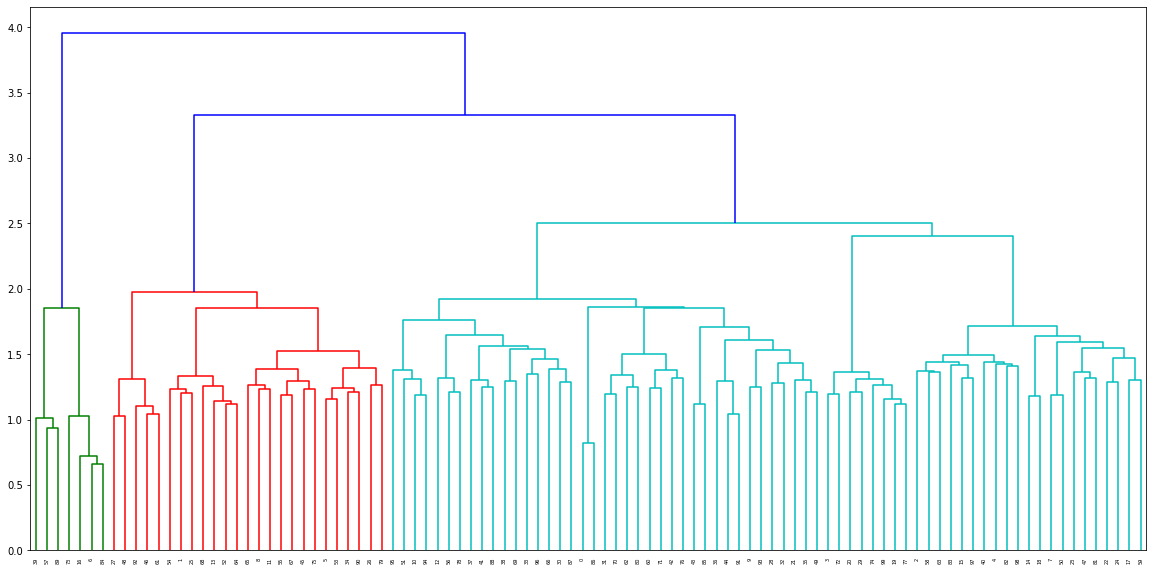

In [15]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(20, 10)) 
dend = shc.dendrogram(shc.linkage(cosine_similarity_df, method="ward"))

In [16]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=3, affinity="euclidean", linkage="ward")  
cluster.fit_predict(cosine_similarity_df)

array([0, 2, 0, 0, 0, 2, 1, 0, 2, 0, 0, 2, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 2, 2, 0, 2, 0, 0, 0, 2, 2, 2, 2, 0, 1, 0, 0, 0, 2, 0, 0, 2, 2,
       0, 2, 2, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

### Bag of Words

Now that we have the counts we can begin forming a term frequency matrix or bag of words. To illustrate what I mean I will pass in the joke text into the bag_or_words function:

In [17]:
data612.bag_of_words(jokes)

word,!,!',"""a","""actually","""agh,","""ah,","""amal.""","""an","""and","""anybody",...,"you,",you.,"you.""",you.you,you?,"you?""",young,younger,your,yourself
index,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
97,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


As you can see there are 2,073 terms in the bag of words, however some of them should be combined.  I created the preprocess_jokes() function that allows me to clean up the text.  There are multiple transformation that can be preformed but they must be explicitly called.  I'm going to remove all contractions (I'm becomes I am), numbers, puctuation marks and stop words from the jokes.  I am also going to lemmatize the words.

In [18]:
preprocessed_jokes = data612.preprocess_jokes(jokes, remove_contractions=True, remove_numbers=True, remove_punctuation_marks=True, remove_stop_words=True, lemmatize_words=True)
term_frequency_matrix = data612.bag_of_words(preprocessed_jokes)
term_frequency_matrix

word,abortion,accompanied,accounting,acquitted,actual,actually,add,address,addressed,adoption,...,yen,yes,yesterday,yesterdaya,york,young,younger,youyou,zipper,zool
index,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
97,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


There are now 1,425 terms in the matrix.  I am going to use this matrix to form the content based recommendations.  In addition to it I will use a normalized matrix:

In [19]:
normalized_term_frequency_matrix = data612.bag_of_words(preprocessed_jokes, normalize=True)
normalized_term_frequency_matrix

word,abortion,accompanied,accounting,acquitted,actual,actually,add,address,addressed,adoption,...,yen,yes,yesterday,yesterdaya,york,young,younger,youyou,zipper,zool
index,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.213201,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.208514,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


### Similar Jokes

Now that we have the term frequence matrices we need to find which jokes are similar.  There are multiple approaches we could use.  We're going to try a couple of them out and see how their results change.

#### Cosine Similarity

The first way we will find similar content is based off of the cosine similarity.  Cosine similarity ranged from -1 to 1 with 1 being perfectly similar and -1 being perfectly dissimilar.

In [20]:
cosine_similarity_df = data612.cosine_similarity(term_frequency_matrix)
cosine_similarity_df.stack().mean()

0.03859023830514679

The mean cosine similarity value is .27.  Let's visualize the cosine similaries in a heatmap.

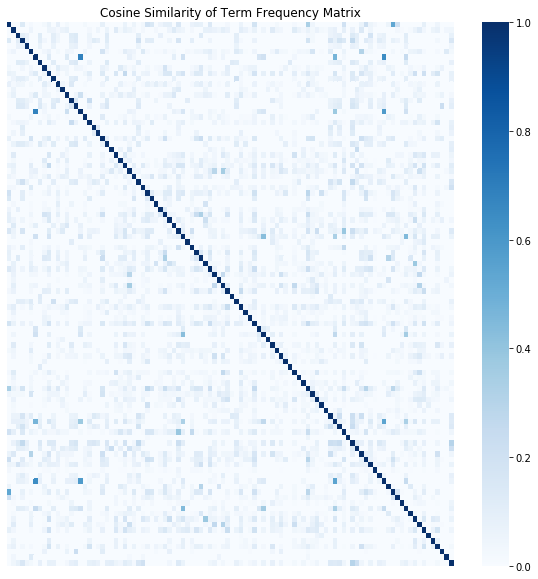

In [21]:
plt.figure(figsize=(10, 10))
plt.title("Cosine Similarity of Term Frequency Matrix") 
sb.heatmap(cosine_similarity_df, cmap="Blues", xticklabels=False, yticklabels=False)
plt.ylabel('')
plt.xlabel('')
plt.show()

There aren't really strong relationships in this data which is understandable.  To have a high cosine similarity score they would need to have the same words in the same number.  This just doesn't occur.  We can normalize the normalized term frequency matrix to see if that improves things.

In [22]:
normalized_cosine_similarity_df = data612.cosine_similarity(normalized_term_frequency_matrix)
normalized_cosine_similarity_df.stack().mean()

0.038590238305146796

The mean is the same as the non-normalized data.  Again the jokes would have to have the same words.  This is a limitation of using the text of the jokes to find comparable jokes.

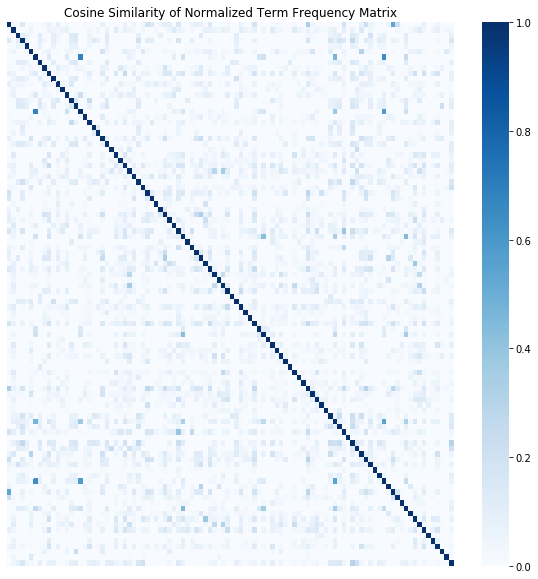

In [23]:
plt.figure(figsize=(10, 10))
plt.title("Cosine Similarity of Normalized Term Frequency Matrix") 
sb.heatmap(normalized_cosine_similarity_df, cmap="Blues", xticklabels=False, yticklabels=False)
plt.ylabel('')
plt.xlabel('')
plt.show()

#### Hierarchical Clustering

We can also hierarchical clusterning to find similar jokes.  We will base this on the cosine difference.

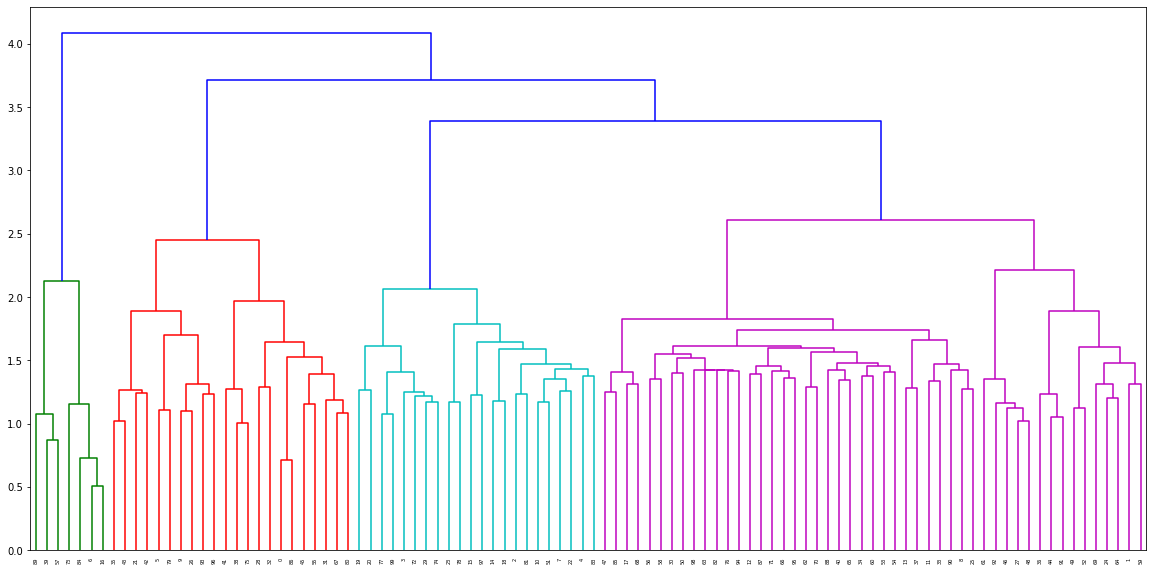

In [24]:
normalized_cosine_similarity_df = data612.cosine_similarity(normalized_term_frequency_matrix, return_difference=True)
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(20, 10)) 
dend = shc.dendrogram(shc.linkage(normalized_cosine_similarity_df, method="ward"))

In [25]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=4, affinity="euclidean", linkage="ward")  
cluster.fit_predict(normalized_cosine_similarity_df)

array([2, 0, 3, 3, 3, 2, 1, 3, 0, 2, 3, 0, 0, 0, 3, 3, 1, 0, 3, 3, 3, 2,
       3, 3, 0, 0, 2, 0, 2, 3, 0, 2, 2, 0, 0, 2, 0, 0, 2, 1, 0, 2, 2, 2,
       0, 2, 0, 0, 0, 0, 0, 3, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 0, 3, 1, 3, 2, 0, 3, 3, 2, 2, 3, 0, 3, 1, 0, 2, 0,
       0, 1, 0, 0, 0, 2, 0, 0, 2, 3, 0, 3], dtype=int64)

In [26]:
#cosine_difference_df = data612.cosine_similarity(term_frequency_matrix, return_difference=True)
#normalized_cosine_difference_df = data612.cosine_similarity(normalized_term_frequency_matrix, return_difference=True)
#cluster.fit_predict(normalized_cosine_difference_df)

## Evaluation

Now that we have some models to recommend content we're going to see how well they preform.  We will rely on the training and test sets from the first project to do this.  First we will read it in:

In [27]:
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#    print(df.mean(axis=0))

Next we will identify records in the ratings 

In [28]:
#.fillna(0)
#user_clusters = pd.DataFrame(cluster.fit_predict(train_df), index = train_df.index)
#user_clusters